# Application: Cavity Flow

One of the most common validation cases in CFD is the lid-driven cavity flow.  We take a square cavity filled with a fluid and set the velocity of the lid to some constant value.  The flow within the cavity is driven by the lid, a spiral flow pattern develops and two distinctive pressure zones are visible in the upper corners against the lid.

<img src='./figures/drivencavity.svg' width=350>

In [40]:
import numpy

The Poisson equation is an elliptic PDE which almost always means using an iterative solver.  We're going to use the Jacobi method.  There are better ways, but that's beside the point.  

Here's the pressure Poisson equation:

\begin{align}
p_{i,j}^{n+1} &= \frac{1}{4}\left(p_{i+1,j}^{n}+p_{i-1,j}^{n}+p_{i,j+1}^{n}+p_{i,j-1}^{n}\right) \\
&-\frac{\rho \Delta x}{16} \left( \frac{2}{\Delta t} \left(u_{i+1,j} - u_{i-1,j} + v_{i,j+1} - v_{i,j-1}\right) \right . \\
&-\frac{2}{\Delta x}\left(u_{i,j+1} - u_{i,j-1} \right) \left(v_{i+1,j} - v_{i-1,j} \right) \\
&- \left . \frac{\left(u_{i+1,j} - u_{i-1,j} \right)^2}{\Delta x} 
- \frac{ \left(v_{i,j+1} - v_{i,j-1} \right)^2 }{\Delta x} \right) \\
\end{align}

That looks a little nasty, but we only care about the top line when we iterate, since the bottom three lines depend only on values that don't change when we're correcting the pressure field.  Because it doesn't change, we break it out into a separate function.

In [41]:
def velocity_term(b, rho, dt, u, v, dx):
    b[1:-1, 1:-1] = (
        rho * dx / 16 *
        (2 / dt * (u[1:-1, 2:] -
                    u[1:-1, :-2] +
                    v[2:, 1:-1] -
                    v[:-2, 1:-1]) -
        2 / dx * (u[2:, 1:-1] - u[:-2, 1:-1]) *
                 (v[1:-1, 2:] - v[1:-1, :-2]) -
        (u[1:-1, 2:] - u[1:-1, :-2])**2 / dx -
        (v[2:, 1:-1] - v[:-2, 1:-1])**2 / dx)
                     )

    return b

Now, to calculate the pressure field, we pass in the original pressure field, the value `b` (which is the result of the `velocity_term` function above) and a target value for difference between two iterates.  We repeatedly update the pressure field until the difference of the L2 norm between two successive iterations is less than that target value.

In [42]:
def pressure_poisson(p, b, l2_target):
    iter_diff = l2_target + 1
    n = 0
    while iter_diff > l2_target and n <= 500:

        pn = p.copy()
        p[1:-1,1:-1] = (.25 * (pn[1:-1, 2:] +
                               pn[1:-1, :-2] +
                               pn[2:, 1:-1] +
                               pn[:-2, 1:-1]) -
                               b[1:-1, 1:-1])

        p[:, 0] = p[:, 1]   #dp/dx = 0 at x = 0
        p[:, -1] = p[:, -2] #dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   #dp/dy = 0 at y = 0
        p[-1, :] = 0        #p = 0 at y = 2
        
        if n % 10 == 0:
            iter_diff = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
                    
        n += 1
        
    return p

In the interests of brevity, we're only going to worry about the pressure Poisson solver.  The rest of the 2D Navier-Stokes solution is encapsulated in the function `cavity_flow`, which we've prepared ahead of time and saved in a helper file. If you want to dig deeper into how the `cavity_flow` function works, check out "The 12 Steps to Navier-Stokes" at [CFD Python](https://github.com/barbagroup/CFDPython).

For now, though, we just need to import the function:

In [43]:
from snippets.ns_helper import cavity_flow

We'll also load up [pickled](https://docs.python.org/3/library/pickle.html) initial conditions, so we can reliably compare final solutions.

In [44]:
import pickle

In [45]:
def run_cavity():
    nx = 41
    ny = 41
    with open('IC.pickle', 'rb') as f:
        u, v, p, b = pickle.load(f)

    dx = 2 / (nx - 1)
    dt = .005
    nt = 1000
    
    u, v, p = cavity_flow(u, v, p, nt, dt, dx, 
                         velocity_term, 
                         pressure_poisson, 
                         rtol=1e-4)
    
    return u, v, p

So what does this all do?  Let's check it out.

In [46]:
u, v, p = run_cavity()

In [47]:
%matplotlib inline
from snippets.ns_helper import quiver_plot

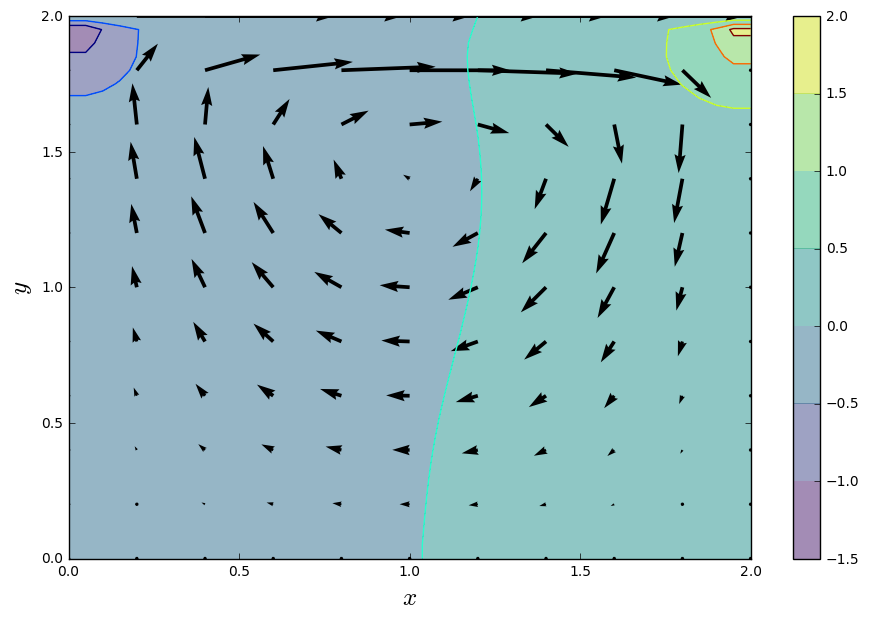

In [48]:
quiver_plot(u, v, p)

#### Save NumPy answers for comparison

This will create a binary file, saved to disk as `numpy_ans.pickle` that contains the values of `u`, `v`, and `p`. 

In [49]:
with open('numpy_ans.pickle', 'wb') as f:
    pickle.dump((u, v, p), f)

Let's profile the `cavity_flow` function and see if there's a specific place that's really hurting our performance.

In [50]:
%timeit run_cavity()

1 loop, best of 3: 483 ms per loop


Remember that we need to load the `line_profiler` extension before we can use the `lprun` magic.

In [51]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [52]:
%lprun -f cavity_flow run_cavity()

## Where is the bottleneck?

Clearly the PPE is the problem here, so let's use `numba` to rewrite it.  

## [Exercise: Speed up the PPE](./exercises/05.Cavity.Flow.Exercises.ipynb#Exercise-1)

In [53]:
from numba import jit

In [54]:
# %load snippets/ppe_numba.py
@jit(nopython=True)
def pressure_poisson(p, b, l2_target):
    J, I = b.shape

    iter_diff = l2_target + 1

    n = 0
    while iter_diff > l2_target and n <= 500:
        pn = p.copy()
        for i in range(1, I - 1):
            for j in range(1, J - 1):
                p[j, i] = (.25 * (pn[j, i + 1] +
                                  pn[j, i - 1] +
                                  pn[j + 1, i] +
                                  pn[j - 1, i]) -
                                  b[j, i])

        for j in range(J):
            p[j, 0] = p[j, 1]
            p[j, -1] = p[j, -2]

        for i in range(I):
            p[0, i] = p[1, i]
            p[-1, i] = 0

        if n % 10 == 0:
            iter_diff = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))

        n += 1

    return p


Since we have redefined the `pressure_poisson` function, we can run `run_cavity` again and we'll be using the new and improved `jit`ted PPE. 

We don't want to overwrite our results, so we can choose different variable names to store the final velocity and pressure fields.

In [55]:
u_numba, v_numba, p_numba = run_cavity()

We use `numpy.allclose` to check that each value of the Python and Numba fields match to within a specified tolerance (the default tolerance is 1$\tt{E}^-$08).

In [56]:
assert numpy.allclose(p, p_numba)
assert numpy.allclose(u, u_numba)
assert numpy.allclose(v, v_numba)

If there were no errors raised by the previous cell, then the two answers match.  Hooray! 
If the answers match, we should see the same plot as above.  If they don't match, we can also check the plot to see if we're just a little bit off or completely wrong (although that can be hard to judge sometimes).

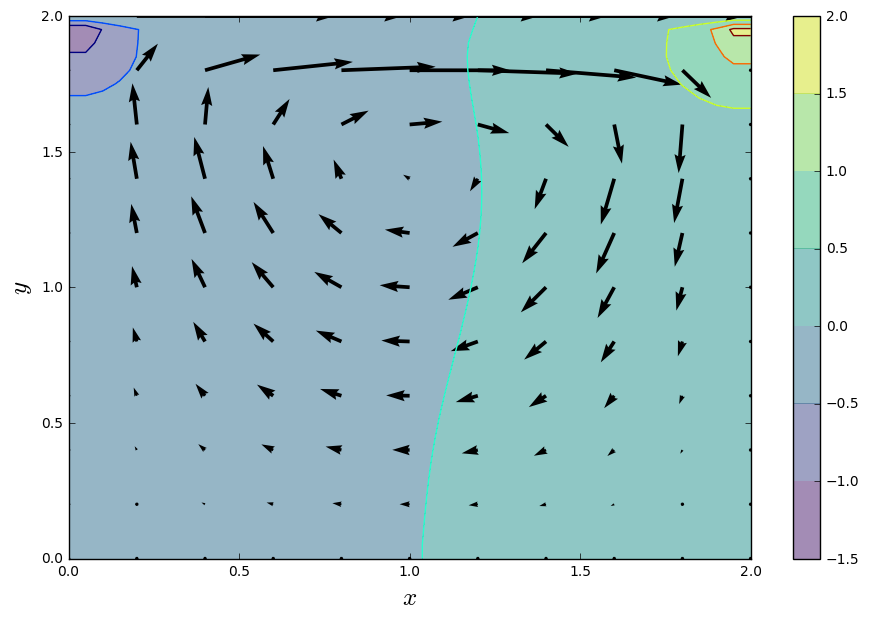

In [57]:
quiver_plot(u_numba, v_numba, p_numba)

And now we can check to see how much the performance has been improved:

In [58]:
%timeit run_cavity()

1 loop, best of 3: 217 ms per loop


Not as spectacular as some of the other examples, but remember, we started off using NumPy arrays, not regular nested Python loops, so this is still a very respectable speedup.  

Now if we re-profile the code, we can see how the runtime percentages have shifted around the improved PPE.  It's almost certainly going to remain the most expensive part of the solve, but it should be a smaller percentage overall.

In [62]:
%lprun -f cavity_flow run_cavity()

## One more bit of optimization?

As we improve the performance of the Pressure Poisson function, the profiling results will change and indicate other possible hotspots that we want to improve. It can be hard to know when to _stop_ improving, to recognize that the gains are not worth what you are investing in rewriting code. 

In the profile above (after rewriting the PPE) you'll notice that the `velocity_term` now occupies a larger percentage of the total run time. Here's a rewritten version of `velocity_term` that makes use of Numba so you can compare how much more performance we might be able to eke out of this simple cavity flow solver.

In [60]:
@jit(nopython=True)
def velocity_term(b, rho, dt, u, v, dx):
    J, I = b.shape
    
    for i in range(1, I):
        for j in range(1, J):
            b[j, i] = (
            rho * dx / 16 * 
            (2 / dt * (u[j, i + 1] - 
                      u[j, i - 1] + 
                      v[j + 1, i] - 
                      v[j - 1, i]) - 
            2 / dx * (u[j + 1, i] - u[j - 1, i]) * 
                     (v[j, i + 1] - v[j, i - 1]) - 
            (u[j, i + 1] - u[j, i - 1])**2 / dx - 
            (v[j + 1, i] - v[j - 1, i])**2 / dx)
            )
    return b

In [61]:
%timeit run_cavity()

1 loop, best of 3: 180 ms per loop
